# Let's Find Coronal Hole: Day 2

Welcome to the second day of Let's find CH project. Today we are going to do the actual sciency stuff, which is defining the boundary of CH and extracting its properties. 

First thing first, we have to download the sunpy and aiapy library

In [15]:
# Only Run in Google colab
# Also don't forget to run it everytime we start colab because colab is a virtual machine that will not store any data
# !pip install sunpy
# !pip install aiapy

then copy the data folder

In [16]:
# Clone data storage
# !git clone https://github.com/nawinnova/LetsFindCH_data.git

and import the library that we are going to use today.

In [17]:
import glob

import sunpy.map
from sunpy.map.maputils import all_pixel_indices_from_map,sample_at_coords,all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.net import Fido
from sunpy.net import attrs as a

from aiapy.calibrate import normalize_exposure, register, update_pointing, correct_degradation

import numpy as np

from scipy import ndimage
from scipy.stats import mode

import matplotlib.pyplot as plt

import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord

# import datetime as dt

import warnings
warnings.simplefilter('ignore')

Also define the aiaprep function that we use to prepare the data. (Refer to Day1 notebook)

In [18]:
#Function use to prepare map obtained from AIA
def aiaprep(aiamap):
    aiamap_updated_pointing = update_pointing(aiamap) #update metadata to recent pointing
    aiamap_registered = register(aiamap_updated_pointing) #registered: rotate align w/ solar north and rescale to match 0.6 pixel resolution
    aiamap_norm = normalize_exposure(aiamap_registered) #Normalized exposure time for each image: unit (DN/pixel/s)
    aiamap_corr = correct_degradation(aiamap_norm) #Correct Degradation effect of Instrument
    aiamap_rot = aiamap_corr.rotate()

    return aiamap_rot

Let's start the work for today! First thing is to take a look at the first AIA193 images in your folder

In [19]:
#Access files from data folder
#Don't forget to change CH_instuctor to your CH folder
filelist_AIA = sorted(glob.glob('/LetsFindCH_data/CH_Instructor/AIA193/*.fits'))
#Select first image (first element => index 0)
#Change the image file by change the index
fileAIA = filelist_AIA[0]

Read the file and using aiaprep to prepare the data

In [20]:
aiamap = sunpy.map.Map(fileAIA)

In [21]:
aiamap_prep = aiaprep(aiamap)

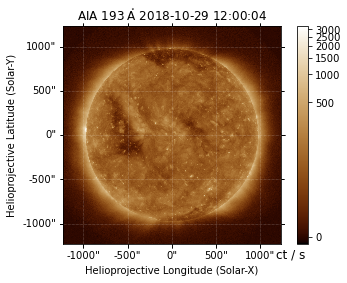

In [22]:
aiamap_prep.peek()

Then choose the appropriate field-of-view of the zoomed in map to covered around the CH

In [23]:
# Choose submap region
bottom_left_x = -600 #x coordinate
bottom_left_y = -400 #y coordinate
# We define the bottomleft coordinate using SkyCoord function
bottom_left = SkyCoord(bottom_left_x * u.arcsec, bottom_left_y* u.arcsec, frame= aiamap_prep.coordinate_frame)
# Define width and height for our zoom in map
w = 800 #Width
h = 1000 #Height
# Crop our map using submap function
# We will create two submao, which we are going to use next
subaiamap = aiamap_prep.submap(bottom_left, width = w*u.arcsec, height = h*u.arcsec)
subaiamap_mask = aiamap_prep.submap(bottom_left, width = w*u.arcsec, height = h*u.arcsec)

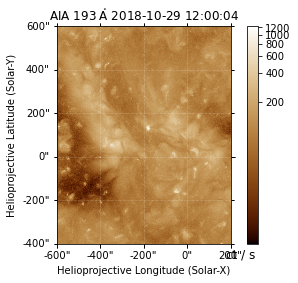

In [24]:
subaiamap.peek()

These steps are as far as we go yesterday. The next step now is to figuring out we can defined the boundary of coronal hole

If we look at the map, we can see that the CH appears darker than surrounding regions, which means that the pixel corresponding with CH region must have lower intensity. Therefore, maybe we can define a threshold of intensity which will categorise if the pixel is inside CH or not?

Your task is to find the threshold that will return the appropriate CH boundary.

The good place to start is looking at the distribution of pixel inside the map based on intensity. We can do that by plotting a histogram.

In [25]:
# Define the number of bins: The number of bins will affect the shape of distribution
num_bins = 1000
bins = np.linspace(subaiamap.min(), subaiamap.max(), num_bins)

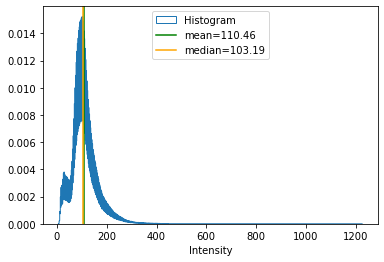

In [26]:
# Plot Histogram
fig = plt.figure()
# Note that we have to use ``.ravel()`` here to avoid matplotlib interpreting each
# row in the array as a different dataset to histogram.
plt.hist(subaiamap.data.ravel(), bins=bins, label='Histogram', histtype='step' ,density = True)
plt.xlabel('Intensity')
plt.axvline(subaiamap.data.mean(),
            label='mean={:.2f}'.format(subaiamap.data.mean()), color='green')
plt.axvline(np.median(subaiamap.data),
            label='median={:.2f}'.format(np.median(subaiamap.data)), color='Orange')
#Change the scale to be logarithimic on y axis
# plt.yscale('log')
plt.legend(loc=9)
#Set the limit of x axis to zoom in
# plt.xlim(0,200)

Using the histogram we plotted above to figure out what the threshold should be. After you have an initail guess, try plotting them to see if you are heading in the right way or not.

Here is the function that I wrote to define coronal hole boundary

In [27]:
#Function used to mask the area outside solar disc
def mask_solardisc(subaiamap):
    hpc = all_coordinates_from_map(subaiamap)
    mask = coordinate_is_on_solar_disk(hpc)
    return mask

#Define Coronal Hole Boundary - Return it as the array where CH pixels are defined define as 1 and anywhere else are defined as 0
def define_CHB (aiamap, subaiamap, subaiamap_mask, thr, filt_order): 
    mask_disk = mask_solardisc(subaiamap)
    mask_disk_full = mask_solardisc(aiamap)
    #Make the data outside solar disk = 0
    aiamap_data_disk = np.where(mask_disk_full, aiamap.data, 0)
    #Select CHB according to given threshold
    mask = subaiamap.data > thr
    subaiamap_mask.mask = mask
    #Gaussian Filtering to Connect Smaller Region and smooth boundary
    data1 = ndimage.gaussian_filter(subaiamap.data * ~mask, filt_order) #gaussian filtering
    #labels the area define in CH
    subaiamap_new = sunpy.map.Map(data1, subaiamap.meta)
    labels, n = ndimage.label(subaiamap_new.data)
    #Select only biggest CH
    vallabel = mode(labels[np.nonzero(labels)])
    labels_true = np.where(labels == vallabel[0], labels, 0)
    #Fill Bright spots in CH (We neglected them)
    labels_true = ndimage.binary_fill_holes(labels_true).astype(int)
    # Check only coordinate on disk
    labels_true = np.where(mask_disk, labels_true,0)
    return labels_true

We will extract the hole boundary using function called **define_CHB**. We can change the intensity threshold for our boundary in **thr** parameter, and we can also change the order of smoothing using **filt_order** parameter.

In [28]:
CHB = define_CHB(aiamap, subaiamap, subaiamap_mask, thr = 40, filt_order = 5)

This function will return array with the same shape of our input submap. But it will mark area inside our target CH as 1 and outside CH as 0

In [29]:
CHB

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let's plot them....

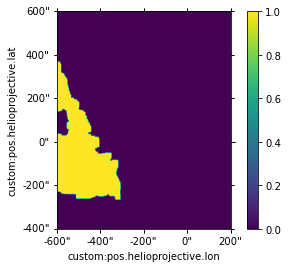

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=subaiamap)
im = ax.imshow(CHB,origin='lower')
plt.colorbar(im)

Then let's try to plot our define boundary onto our zoom-in map

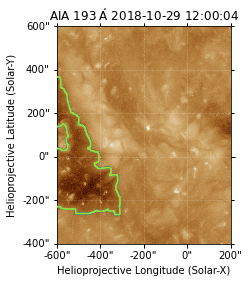

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection = subaiamap)
subaiamap.plot()
ax.contour(CHB, colors='black', linewidths = 0.5) #You can change color and line widths

Now you can redo the define process using different threshold until you get the appropriate CH. There is no definite answer or value, just trying to adjust it until you are satisfied with the results :)

When we get the appropriate threshold. we can save our plots as images (png or jpg) using savefig function. (You can also right click at the image to save them as well though)

In [ ]:
# Save plots using this command, we can also have option such as choosing name, select the resolution or eliminate white space
fig.savefig("CHB1_AIA.png", dpi=200, bbox_inches='tight')

The saved images will appear in the file tree, which we can download to our computer later (before disconnect from Colab). Please save the image to your computer, since we are going to use them for creating movies tomorrow.

Now that we obtained the boundary, we can move on to derive properties of CH. The first one that we are going to look at is the area of CH.

Since we are projecting 3D sphere to 2D circle, we have to correct the project area per one pixel using this function below.

In [31]:
#Area calculation for each submap
def AreaCalc(submap):
    origin = SkyCoord(0 * u.arcsec, 0 * u.arcsec, frame= submap.coordinate_frame)
    submap_coord = all_coordinates_from_map(submap)
    Distance_rad = submap_coord.separation(origin).radian
    #Area per 1 pixel (Mm^2)
    onepixarea = ((submap.scale[0].to(u.radian/u.pixel).value * submap.dsun.value)**2)/10**12#Mm^2 unit
    #Corrected area
    Eff_area = onepixarea/np.cos(Distance_rad)
    
    return Distance_rad, Eff_area

In [32]:
Distance_array, Areaperpix_array = AreaCalc(subaiamap)

This function will return two arrays. First one is the angular distance from each pixel to the center of solar disc (0,0) pixel. The second array will return the corrected area of each pixel in the submap (The unit is Megametre square (Mm^2). Note: 1 Mm = 1000 km = 1000000 m

Try plotting **Areaperpix_array** .......

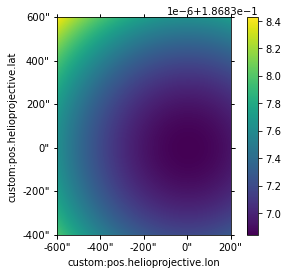

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=subaiamap)
im = ax.imshow(Areaperpix_array,origin='lower')
subaiamap.draw_grid()
plt.colorbar(im)

You can see that the area per pixel is lowest at coordinate (0,0) and gradually get higher with the distance away from center.

Now that we know area per pixel, we can just multiply it with the **CHB** array to get the total area

In [43]:
CHarea = np.sum(CHB*Areaperpix_array)
print('Area of CH =', CHarea,'Mm^2')

Area of CH = 48925.061441374324 Mm^2


Copy this value to the google sheet, because we are going to use it later.

Next, we are going to investigate the magnetic properties of CH. Therefore, we have to download another image which contains magnetic field data. It will be in the folder named HMI.

In [44]:
# Access HMI image
# Don't forget to change CH_instuctor to your CH folder
filelist_HMI = sorted(glob.glob('/LetsFindCH_data/CH_Instructor/HMI/*.fits'))
#Select first image (first element => index 0)
fileHMI = filelist_HMI[0]

We can still read them using sunpy.map.Map and quickplot them using peek

In [45]:
hmimap = sunpy.map.Map(fileHMI)

In [ ]:
hmimap

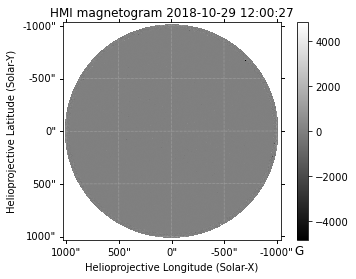

In [46]:
hmimap.peek()

We can see that the color scale is not appropriate and the images is upside-down. We can fix this using function PrepHMI below.

In [47]:
def PrepHMI(hmimap):
    # Rotate HMI magnetogram
    out_hmi = hmimap.rotate(order=3)
    #Saturated High Values: (-50,50) g
    out_hmi.plot_settings['norm'] = plt.Normalize(-50, 50)
    return out_hmi

In [48]:
hmimap_prep = PrepHMI(hmimap)

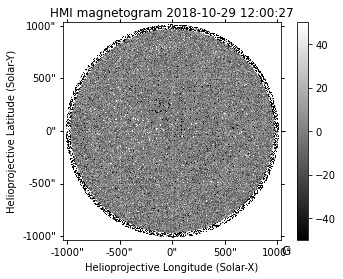

In [49]:
hmimap_prep.peek()

Let's take a look at some properties of this HMI map and compare them to AIA map

In [50]:
print('HMI scale = ', hmimap_prep.scale)
print('HMI date = ', hmimap_prep.date)
print('AIA scale = ', aiamap_prep.scale)
print('AIA date = ', aiamap_prep.date)

HMI scale =  SpatialPair(axis1=<Quantity 0.504015 arcsec / pix>, axis2=<Quantity 0.504015 arcsec / pix>)
HMI date =  2018-10-29T12:00:27.200
AIA scale =  SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
AIA date =  2018-10-29T12:00:04.840


You may notice that scale and time of HMI map is a bit off compared to AIA map. Them time is not a big deal, but we have to fix the scale to apply our CH boundary correctly to HMI map.

We can fix the scale to align with AIA map using reproject_to function. This function will reproject the HMI map onto AIA map.

In [51]:
# Fix plate scale aligning HMI and AIA using reproject_to function
hmimap_reproject = hmimap_prep.reproject_to(aiamap_prep.wcs)

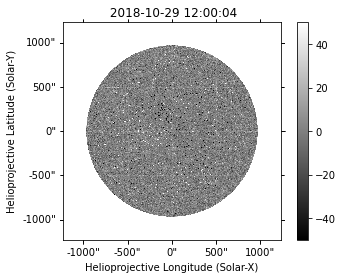

In [52]:
hmimap_reproject.peek()

If we look at the new scale, we can see that the scale has changed to match the AIA map scale. (Note that 1 deg = 3600 arcsec)

In [53]:
print('HMI scale = ', hmimap_reproject.scale)
print('HMI date = ', hmimap_reproject.date)
print('AIA scale = ', aiamap_prep.scale)
print('AIA date = ', aiamap_prep.date)

HMI scale =  SpatialPair(axis1=<Quantity 0.00016667 deg / pix>, axis2=<Quantity 0.00016667 deg / pix>)
HMI date =  2018-10-29T12:00:04.840
AIA scale =  SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
AIA date =  2018-10-29T12:00:04.840


Then we will crop our reprojected map using submap. We can use the same bottomleft coordinate, width and height that we define earlier

In [55]:
# Crop map -> Using the same parameter from AIA map
subhmimap = hmimap_reproject.submap(bottom_left, width = w*u.arcsec, height = h*u.arcsec)

Then overplot the boundary of CH onto this zoom in HMI map

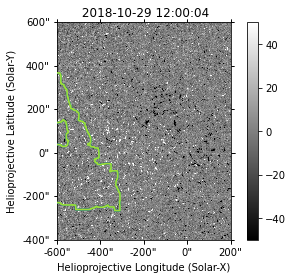

In [56]:
# Apply contour to subhmimap
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection = subhmimap)
subhmimap.plot()
ax.contour(CHB)
plt.colorbar()

In [ ]:
# Save the figure using this command or just right click the image.
fig.savefig("CHB1_HMI.png", dpi=200, bbox_inches='tight')

We can also plot AIA map and HMI map side by side...

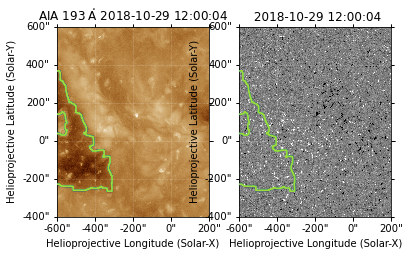

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection = subaiamap)
subaiamap.plot()
ax1.contour(CHB)
ax2 = fig.add_subplot(1,2,2,projection = subhmimap)
subhmimap.plot()
ax2.contour(CHB)

In [ ]:
# Save the figure using this command or just right click the image.
fig.savefig("CHB1_AIAandHMI.png", dpi=200, bbox_inches='tight')

Now we can extract magnetic properties from area inside CH. The properties that we are going to obtain are:
- Positive Flux
- Negative Flux
- Unbalanced Flux
- Unsigned Flux
- Mean Magnetic Flux Density

The calculation details will be explained in the slides. We are going to use this function below to get all of five values we are interested in.

In [57]:
def SelectSubarea_HMI(subhmimap, labels, distancearray,areaarray):
    submap_data = subhmimap.data
    #correct Blos projection effect
    Blos_submap = submap_data/np.cos(distancearray)
    Blos_selectarea_data = Blos_submap[labels!=0]
    areaarray_subarea = areaarray[labels!=0]
    #Bpos and Bneg
    Blos_pos = np.where(Blos_selectarea_data > 0, Blos_selectarea_data, 0)
    Blos_neg = np.where(Blos_selectarea_data < 0, Blos_selectarea_data, 0)
    Bflux_pos = np.sum(Blos_pos*areaarray_subarea)
    Bflux_neg = np.sum(Blos_neg*areaarray_subarea)
    Bflux_ub =  Bflux_pos + Bflux_neg
    Bflux_us = Bflux_pos + np.abs(Bflux_neg)    
    # Alternative way to calculate unbalanced and unsigned flux
    # Bflux_ub = np.sum(Blos_selectarea_data*areaarray_subarea)
    # Bflux_us = np.sum(np.abs(Blos_selectarea_data)*areaarray_subarea)
    meanBdens = Bflux_ub/np.sum(areaarray_subarea)
    # meanBdens_us = Bflux_us/np.sum(areaarray_subarea)
    if Bflux_us < 10:
        print('Abnormal data at {}'.format(subhmimap.date))
        print(Blos_selectarea_data)
    return Bflux_pos, Bflux_neg, Bflux_ub, Bflux_us, meanBdens

In [58]:
Bflux_pos, Bflux_neg, Bflux_ub, Bflux_us, meanBdens = SelectSubarea_HMI(subhmimap, CHB, Distance_array, Areaperpix_array)

We can print these values out and copy them to your spreadsheet.

In [59]:
print('Total Positive Flux =',Bflux_pos, r'$ \times 10^{16}$ Mx)')
print('Total Negative Flux =',Bflux_neg, r'$ \times 10^{16}$ Mx)')
print('Total Unbalanced Flux =',Bflux_ub, r'$ \times 10^{16}$ Mx)')
print('Total Unsigned Flux =',Bflux_us, r'$ \times 10^{16}$ Mx)')
print('Magnetic flux density =', meanBdens, 'G')
# print('Unsigned magnetic flux density =', meanBdens_us, 'G')

Total Positive Flux = 253051.3882120369 $ \times 10^{16}$ Mx)
Total Negative Flux = -163345.83276445512 $ \times 10^{16}$ Mx)
Total Unbalanced Flux = 89705.55544758178 $ \times 10^{16}$ Mx)
Total Unsigned Flux = 416397.22097649204 $ \times 10^{16}$ Mx)
Magnetic flux density = 1.8335297453856796 G
Unsigned magnetic flux density = 8.510918713417468 G


That's it for today. Good Job everyone!!!!